In [1]:
import shapely
import patato as pat
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from tqdm.auto import tqdm

In [2]:
def get_lineplot(pa_data, interp_rec, buffer_size=0.005, offset_distance=0.0065, n_samples = 1000):
    body = pa_data.get_rois()["body_", "0"]
    body_points = body.get_polygon().buffer(0.005, join_style=1).buffer(-0.005, join_style=1).exterior.xy
    body_points = np.array(body_points).T
    
    # Divider is the second roi used to get the parallel line.
    divider = pa_data.get_rois()["body_", "1"].get_polygon()
    
    # Get the vector and normal to the dividing line.
    x, y = divider.boundary.intersection(body.get_polygon()).xy
    x0 = np.array([x[0], y[0]])
    n = np.array([-y[1] + y[0], x[1] - x[0]])
    n /= np.linalg.norm(n)
    r = np.array([x[1] - x[0], y[1] - y[0]])
    r /= np.linalg.norm(r)
    
    # Find the point on the boundary of the mouse body that is furthest from this dividing line. The idea is that this will be ~ the spine.
    p_max = max(body_points, key=lambda x1: (x1 - x0) @ n).copy()

    # Use p_max as center of new line.
    d = (p_max - x0)@n
    p_max -= n * offset_distance
    
    # Make a dummy line
    x, y = tuple(zip(p_max - r * 0.03, p_max + r*0.03))

    # Recenter the line
    lineplot = shapely.geometry.LineString(np.array((x,y)).T).intersection(body.get_polygon())
    centroid = lineplot.centroid.xy
    
    # Get the final line centered. 
    x, y = ((centroid[0] - r[0] * 0.01, centroid[0] + r[0] * 0.01), (centroid[1] - r[1] * 0.01, centroid[1] + r[1] * 0.01))
    
    # Now interpolate the desired data. Assuming shape is (1, 1, 1, ny, nx)
    xs = interp_rec.da.coords["x"]
    ys = interp_rec.da.coords["y"]
    
    eval_points = np.array((np.linspace(y[0][0], y[1][0], n_samples), np.linspace(x[0][0], x[1][0], n_samples))).T
    distances = (eval_points[:, 1] - centroid[0]) * r[0] + (eval_points[:, 0] - centroid[1]) * r[1]
    values = interpn((ys, xs), interp_rec[0, 0, 0].da.values.astype(np.float64), eval_points)
    return distances, values, x, y

  0%|          | 0/19 [00:00<?, ?it/s]

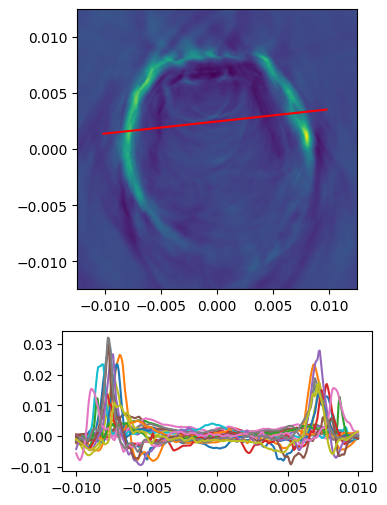

In [3]:
fig, (ax1, ax2) = plt.subplots(2, height_ratios=(2, 1), figsize=(4, 6)) 

i = 0
for f in tqdm(glob.glob("../data/mice/b6/*.hdf5")):
    pa_alb = pat.PAData.from_hdf5(f)
    pa_alb.set_default_recon()
    rec = pa_alb.get_scan_reconstructions()
    
    if ("body_", "0") not in pa_alb.get_rois():
        continue
    if i ==0:
        test_rec = rec.da.values[0, 0, 0].copy()
        xs = rec.da.coords["x"]
        ys = rec.da.coords["y"]
        ax1.imshow(test_rec, origin="lower", extent=(np.min(xs), np.max(xs), np.min(ys), np.max(xs)))
        d, v, x, y = get_lineplot(pa_alb, rec)
        ax1.plot(x, y, c="r")
    
    d, v, x, y = get_lineplot(pa_alb, rec)
    ax2.plot(d, v/1e5)
    i += 1
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

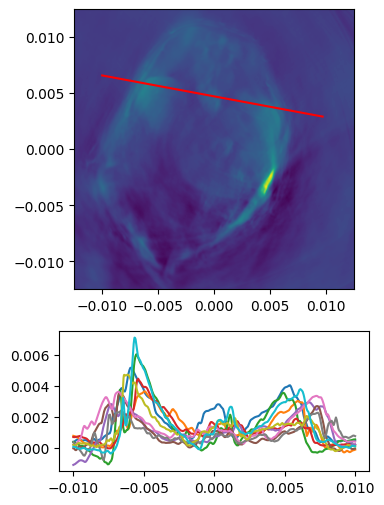

In [4]:
fig, (ax1, ax2) = plt.subplots(2, height_ratios=(2, 1), figsize=(4, 6)) 

i = 0
for f in tqdm(glob.glob("../data/mice/albino/*.hdf5")):
    pa_alb = pat.PAData.from_hdf5(f)
    pa_alb.set_default_recon()
    rec = pa_alb.get_scan_reconstructions()
    
    if ("body_", "0") not in pa_alb.get_rois():
        continue
    
    if i ==0:
        test_rec = rec.da.values[0, 0, 0].copy()
        xs = rec.da.coords["x"]
        ys = rec.da.coords["y"]
        ax1.imshow(test_rec, origin="lower", extent=(np.min(xs), np.max(xs), np.min(ys), np.max(xs)))
        d, v, x, y = get_lineplot(pa_alb, rec)
        ax1.plot(x, y, c="r")
    
    d, v, x, y = get_lineplot(pa_alb, rec)
    ax2.plot(d, v/1e5)
    i += 1
plt.show()

In [5]:
mouse_identities = pd.read_excel("Black 6 Mice Images.ods")
mouse_identities = mouse_identities.set_index("Scan Name")

In [6]:
measurements = []

In [7]:
for f in tqdm(glob.glob("../data/mice/b6/*.hdf5")):
    pa_data = pat.PAData.from_hdf5(f)
    pa_data.set_default_recon()
    rec = pa_data.get_scan_reconstructions()
    thb = pa_data.get_scan_thb()
    so2 = pa_data.get_scan_so2()
    
    if ("body_", "0") not in pa_data.get_rois():
        continue
    d, v, x, y = get_lineplot(pa_data, rec)
    _, v_thb, _, _ = get_lineplot(pa_data, thb)
    _, v_so2, _, _ = get_lineplot(pa_data, so2)
    
    measurements.append({"Scan name": pa_data.get_scan_name(),
                         "Mouse Type": "B6", 
                         "pigmentation": mouse_identities.loc[pa_data.get_scan_name(), "Heavy Pigmentation"],
                         "back pigmentation": mouse_identities.loc[pa_data.get_scan_name(), "Back Pigment"],
                         "front pigmentation": mouse_identities.loc[pa_data.get_scan_name(), "Front Pigment"],
                         "Distance": d,
                         "700nm": v,
                         "THb": v_thb,
                         "sO2": v_so2,
                         "x line": x,
                         "y line": y
                        })
    
    i += 1
plt.show()

  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
for f in tqdm(glob.glob("../data/mice/albino/*.hdf5")):
    pa_data = pat.PAData.from_hdf5(f)
    pa_data.set_default_recon()
    if ("body_", "0") not in pa_data.get_rois():
        continue
    rec = pa_data.get_scan_reconstructions()
    thb = pa_data.get_scan_thb()
    so2 = pa_data.get_scan_so2()
    
    d, v, x, y = get_lineplot(pa_data, rec)
    _, v_thb, _, _ = get_lineplot(pa_data, thb)
    _, v_so2, _, _ = get_lineplot(pa_data, so2)
    
    measurements.append({"Scan name": pa_data.get_scan_name(),
                         "Mouse Type": "Albino", 
                         "pigmentation": "No",
                         "back pigmentation": "No",
                         "front pigmentation": "No",
                         "Distance": d,
                         "700nm": v,
                         "THb": v_thb,
                         "sO2": v_so2,
                         "x line": x,
                         "y line": y
                        })
    
    i += 1
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame(measurements)

df.to_pickle("intermediate results/lineplots.pd")